In [ ]:
# Setup: Don't read/change this
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    %matplotlib inline
    !git clone https://github.com/cybershiptrooper/CV_bootcamp_SWB.git
    %rm ./CV_bootcamp_SWB/cv_bootvamp.ipynb
    %mv ./CV_bootcamp_SWB/* .
    %cd resources
    !source ./get_cifar10.sh
    %cd ..

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from functools import partial

### Basic image ops using numpy

#### Getting to know images, color channels

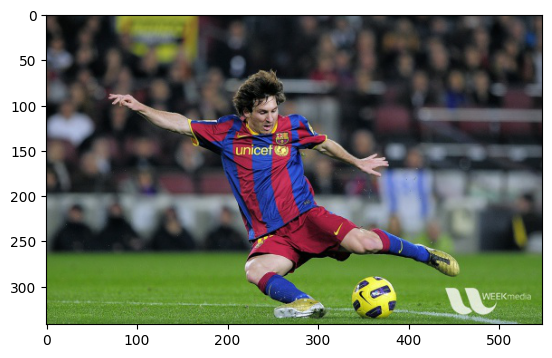

In [2]:
dir = 'resources/ip'
img = plt.imread(f'{dir}/messi5.jpg')
plt.imshow(img)

What is the size of this image?

In [3]:
print(img.shape, img.dtype, img.dtype.itemsize)

(342, 548, 3) uint8 1


In [4]:
# print size in kbs from numpy array
np.prod(img.shape)*img.dtype.itemsize/1024

549.0703125

Text(0.5, 1.0, 'mean')

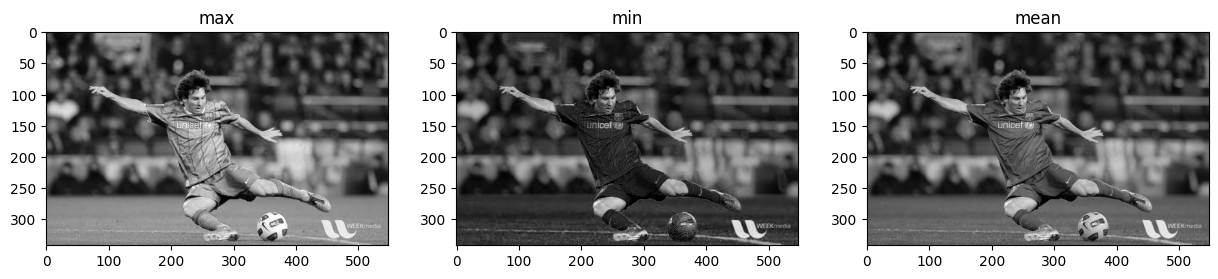

In [5]:
# let's convert this to a grayscale image
max_gray = np.max(img, axis=2)
min_gray = np.min(img, axis=2)
mean_gray = np.mean(img, axis=2)

# let's plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(max_gray, cmap='gray')
ax[1].imshow(min_gray, cmap='gray')
ax[2].imshow(mean_gray, cmap='gray')
ax[0].set_title('max')
ax[1].set_title('min')
ax[2].set_title('mean')

#### Transformations on distributions of intensities

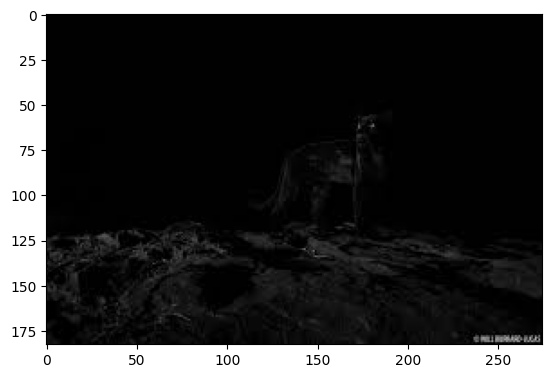

In [6]:
gray = plt.imread(f'{dir}/panther.jpeg', 0)
plt.imshow(gray, cmap='gray')

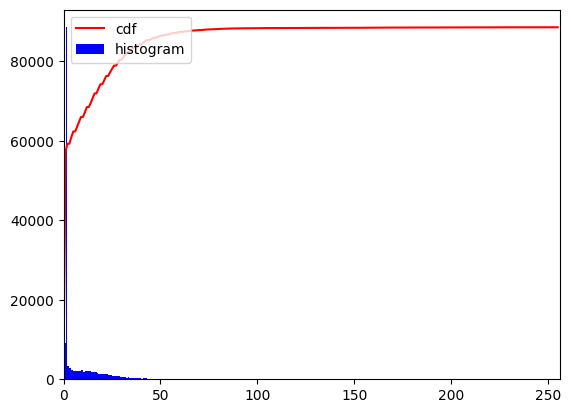

In [7]:
hist, bins = np.histogram(gray, bins=256)
cfd = np.cumsum(hist)
cfd = cfd * float(hist.max())  / cfd[-1]

plt.plot(cfd, color = 'r')
plt.hist(gray.flatten(),256,[0,256], color = 'b')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

Let's try and get to know a simple transformation: gamma correction

The above image is so dark we cant see anything. What can we apply to the image to modify this? Think of what happens to the histogram if you apply a linear map/convex map to all the pixel intensities. 

<details>
<summary>Click to expand</summary>

1. $c.I(x, y)^\gamma$
2. $c.log(1+I(x, y))$

<img src = "./resources/imgs/simple_transforms.png" width=800px>
</details>

In [8]:
if gray.dtype == np.uint8:
    gray = gray.astype(np.float32)/255
gamma = 0.8 

from resources.solns.ip import gamma_correct
interact(gamma_correct, img=fixed(gray), gamma=(0.1, 2.0, 0.1))

interactive(children=(FloatSlider(value=1.0, description='gamma', max=2.0, min=0.1), Output()), _dom_classes=(…

<function resources.solns.ip.gamma_correct(img, gamma)>

Excercise 1: Getting to know numpy

Use your favourite gamma correction value from above and plot it's image

In [9]:
##################################
##### TODO: gamma correction #####
##################################


##################################

Other methods: 
1. Histogram equalization:
    Assume that the image is a continuous random variable sampled from the histogram.
    Find a transformation T such that the PDF of the transformed image T(x) ~ U(0, 1).
2. CLAHE:
    Do histogram equalization on specific window lengths. We will see efficient ways to obtain windows now.
3. Histogram specification: 
    Find a transformation to a specific distribution

For more a formal proof, check out my [notes](./resources/notes/Histogram_Equalization.pdf)

These things are useful preprocessing steps for CV on CCTV/low quality footage/medical IP. 

#### Sliding Windows 
i.e., Convolutions

The idea is similar to 1D signal processing. Although I won't go over much of frequency domain things. Image is a discrete signal over the x and y space instead of time. More often than not, kernels are functions over a square of size `s`. Formally, 

$$
    (i * k)[x, y] = \sum_{i=0}^{s} \sum_{j=0}^{s} i[x+i, y+j] * k[s-i, s-j]
$$

Where, $i :  N^{x+s} \times N^{y+s} \rightarrow [0,1]$ is the image and $k :  N^{s} \times N^{s} \rightarrow [0,1]$ is the kernel

Pictorially, you flip the kernel both horizontally and vertically, and do an elementwise multiplication of the kernel and the image. Later on, we'll see that this doesn't really matter and we do Cross-Correlation. Since we care about deep learning we'll just abuse it while doing learning how to do it. Remember to flip it if you are talking to a signal professor!

<img src="./resources/imgs/correlation.png">


Applications:

1. Removing Noise/Blur
2. Blurring/Smoothing images
3. Edge Detection

Excercise 2: Convolve two gray scale images using numpy


In [10]:
input = np.array([
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
])
kernel = np.array([
    [0, 1],
    [2, 3]
])

##################################
##### TODO: convolution code #####
##################################


##################################

In [11]:
from resources.solns.ip import convolve
print(convolve(input, kernel))

[[19 25]
 [37 43]]


Bonus excercise: Convolve RGB images using numpy. 

And eventually, when we reach deep learning, we need to convolve multiple images in parallel!

Let's try to denoise an image using these operations
There are many kinds of noise out there:
1. White noise (gaussian)
2. Salt and pepper noise (caused by defects in camera diodes)
3. Complicated unknown noise like motion blur

What does the following image look like?

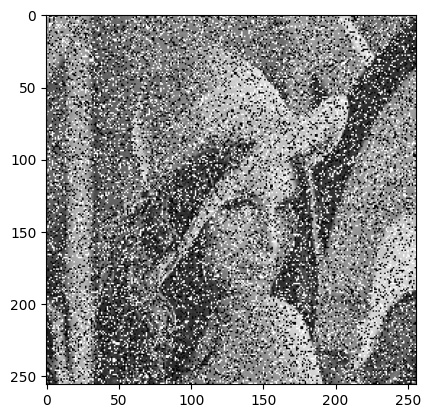

In [12]:
noisy = plt.imread(f'{dir}/lena_salt.png', 0)
plt.imshow(noisy, cmap='gray')

In [13]:
# note that the edges get blurred too
# we can use median filter to avoid this
kernel_size = 5
def median(kernel_size):
    strided = np.lib.stride_tricks.sliding_window_view(noisy, (kernel_size, kernel_size))
    median = np.median(strided, axis=(-2, -1))
    kernel = np.ones((kernel_size, kernel_size))/9
    smoothed = convolve(noisy, kernel)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(noisy, cmap='gray')
    ax[1].imshow(smoothed, cmap='gray')
    ax[2].imshow(median, cmap='gray')
    ax[0].set_title('original')
    ax[1].set_title('smoothed')
    ax[2].set_title('median')

interact(median, kernel_size=(3, 15, 1))

interactive(children=(IntSlider(value=9, description='kernel_size', max=15, min=3), Output()), _dom_classes=('…

<function __main__.median(kernel_size)>

What to do when we have a complicated signal? 

We can use ML methods to model noise. A [Weiner Filter](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node15.html) is a classical way to deal with this. 

Deep learning methods involve generating a clean image using convolutions. We will see this shortly.


Now let's look at `edge detection` using a convolution filter. 
This is analogous to a difference filter. 

$$ \frac{df}{dx} \approx f(x+1) = f(x) $$

We can apply it to the x and y coordinates to detect edges in x/y resp. There are better approximations of this. 


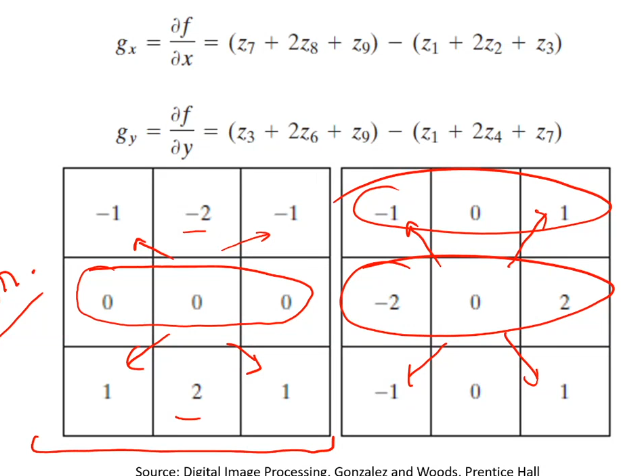


These are called sobel filters. 

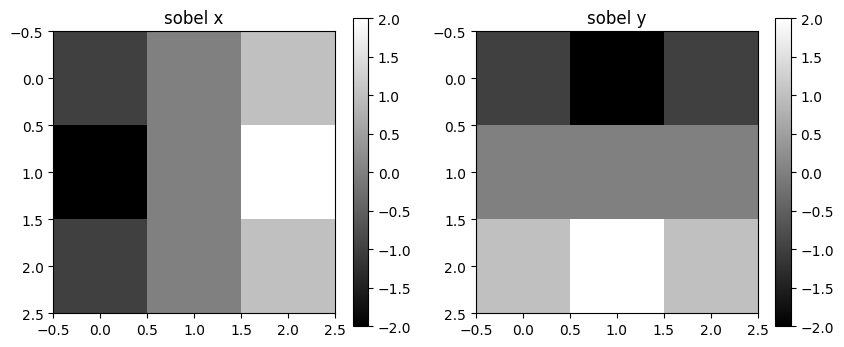

In [14]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

# plot the sobel kernels
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sobel_x, cmap='gray')
ax[1].imshow(sobel_y, cmap='gray')
ax[0].set_title('sobel x')
ax[1].set_title('sobel y')
# add a colorbar
fig.colorbar(ax[0].imshow(sobel_x, cmap='gray'), ax=ax[0], shrink=0.8)
fig.colorbar(ax[1].imshow(sobel_y, cmap='gray'), ax=ax[1], shrink=0.8)

Text(0.5, 1.0, 'sobel y')

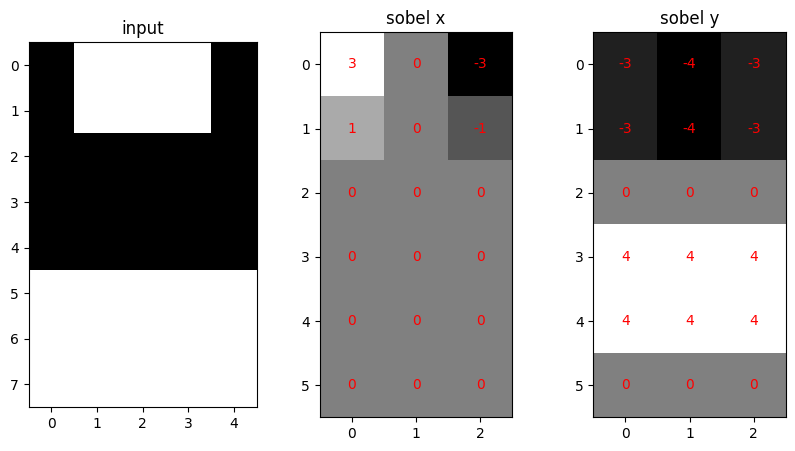

In [15]:
input = np.array([
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1], 
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
])

# plot side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(input, cmap='gray')
output = convolve(input, sobel_x)
ax[1].imshow(output, cmap='gray')
# show values on top of the output
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        ax[1].text(j, i, output[i, j], ha='center', va='center', color='r')

output = convolve(input, sobel_y)
ax[2].imshow(output, cmap='gray')
# show values on top of the output
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        ax[2].text(j, i, output[i, j], ha='center', va='center', color='r')

ax[0].set_title('input')
ax[1].set_title('sobel x')
ax[2].set_title('sobel y')

We will use a laplacian of gaussian filter on an image here. 

![image.png](./resources/imgs/laplace.png)

Note that it is an isotropic filter. So we won't get the information of what direction does the edge belong to from this filter. This just results in a 'sharper' version of the image (and is also used as a sharpen filter in many cases!).

Text(0.5, 1.0, '3x3 kernel')

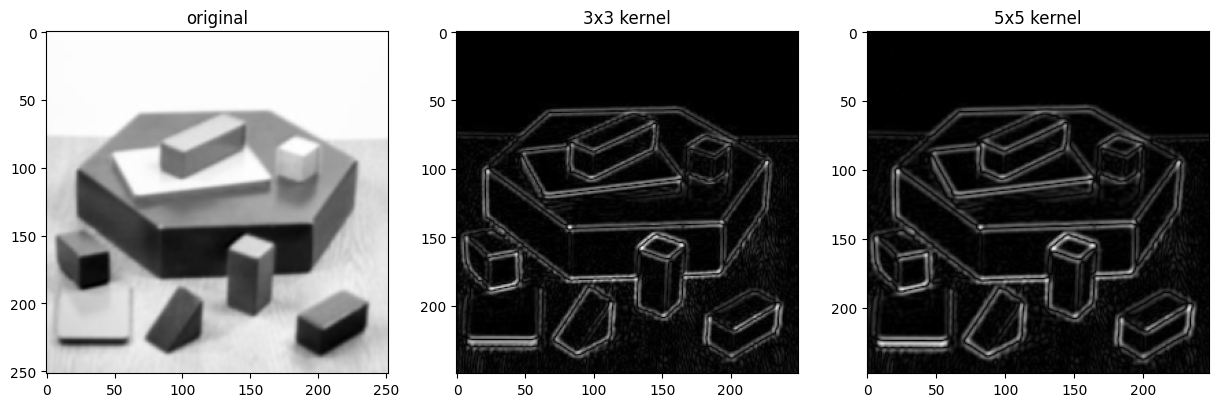

In [16]:
image = plt.imread(f'{dir}/blox.jpg').mean(axis=2)

# 3x3 edge detection kernel
kernel_3by3 = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

# 5x5 edge detection kernel
kernel = np.array([
    [-1, -1, -1, -1, -1],
    [-1,  1,  2,  1, -1],
    [-1,  2,  4,  2, -1],
    [-1,  1,  2,  1, -1],
    [-1, -1, -1, -1, -1]
])

# smooth the image with a gaussian 5x5 kernel
kernel_gaussian = np.array([
    [1,  4,  6,  4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1,  4,  6,  4, 1]
])/256
# we usually smooth the image before applying laplacian as it is sensitive to noise
# try to remove it and see what I'm talking about!
image = convolve(image, kernel_gaussian)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap='gray')
ax[2].imshow(abs(convolve(image, kernel)), cmap='gray')
ax[1].imshow(abs(convolve(image, kernel_3by3)), cmap='gray')
ax[0].set_title('original')
ax[2].set_title('5x5 kernel')
ax[1].set_title('3x3 kernel')

In [17]:
# sharpening
def sharpen(l):
    image = plt.imread(f'{dir}/board.jpg').mean(axis=2)
    if image.dtype == np.uint8:
                image = image.astype(np.float32)/255
    output = convolve(image, kernel)
    # match image and output shapes
    image = image[:output.shape[0], :output.shape[1]]
    sharpened = abs(image + l*(output)) # f + lambda*(f*k) if k's center is positive else f - lambda*(f*k)
    sharpened /= sharpened.max()
    # gamma correct for better visualization
    sharpened = sharpened**(1-l/2)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(sharpened, cmap='gray')
    ax[0].set_title('original')
    ax[1].set_title('sharpened')

interact(sharpen, l=(0, 1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='l', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.sharpen(l)>

### Depth from images

#### Camera in 3 dimensions

Let's use an embarrasingly 2D image to explain this. We'll have a brief look at the most basic form of modelling- 

<details>
<summary>the pinhole camera</summary>

<img src = "./resources/imgs/pinhole.png" width = 600px>

Note that this is just an inverted version of a real life camera. 
We'll take the focus of the pinhole camera as `f` across x and y. 

$$
x = \frac{P_x.f}{z}, 
y = \frac{P_y.f}{z}
$$
</details>

#### 3D modelling when we don't know the camera model

For the theoretically inclined people out here, this is based on projective geometry. We cannot represent 3D transformations seen above as linear maps in 2D(note that these are linear maps on coordinate vector space, and not on pixel intensities, as seen before). To overcome this, we treat the image plane as a $(x, y, 1)$, i.e., a plane in the 3d world $(x, y, z)$, lying at the z coordinate/depth of 1. Then the transformation looks something like this: 

<img src ="./resources/imgs/homography.png" width = 1000px>

For any two arbit. planes, 

$(a_1, a_2)$, $(b_1, b_2)$ are basis vectors for the two planes resp., the matrices $A = (a_1, a_2, a_0)$ and  $B = (b_1, b_2, b_0)$ completely define the plane. A point can be represented by $$(p_1, p_2, 1) \in plane(A): p_1a_1 + p_2a_2 + a_0 = Ap$$ and, $$(q_1, q_2, 1) \in plane(B): q_1b_1 + q_2b_2 + b_0 = Bq$$
resp. Note that both of these new points are in different local coordinate frames. We need to map them using the global frame. 

We map the two planes with a bijection: the point of incidence of a ray from the origin(i.e., the camera) to the planes. So for any pair of points $p = (p_1, p_2, 1)$ and $q = (q_1, q_2, 1)$, there exists a scalar $\alpha(q)$, s.t.

$$Ap = \alpha(q).Bq$$
or, 

$$ p = \alpha(q).A^{-1}Bq$$

What are the assumtions made here? Will it work for any 3D object? Is A invertible? known? What is $\alpha(q)$? What can we say about the position of the camera? Isn't it constant?

We will use my [notes](./resources/notes/understanding_homography.pdf) to understand how to use this to stich images together, on a superficial level. There is a lot more to be found there!


There are many other domains in image processing that were not covered here. I recommend using Digital Image Processing, by Rafael C. Gonzalez([online version](https://sde.uoc.ac.in/sites/default/files/sde_videos/Digital%20Image%20Processing%203rd%20ed.%20-%20R.%20Gonzalez,%20R.%20Woods-ilovepdf-compressed.pdf)) as a reference. 

You can answer many questions using simple image processing algorithms like:
1. How can you detect pen strokes in an image of a notebook? (bitmap tracers)
2. How can we detect faces using just convolutions and basic linear algebra? (haar cascades/wavelets to detect face features + something simple like svd)
3. How to compress images? How are jpegs, etc. made? 
4. Can we remove salt and pepper noise without non linear convolutions? (morphological transforms)
5. How is a CT scan generated? (radon transforms)

_______________________

This concludes the basic image processing part. Let's move on to deep learning. 

### Bringing in the function approximators

<img src = "./resources/imgs/agraph1.png" style="background-color:white;">

<details>
<summary>List of things:</summary>

1. video 
2. multi modal/t<->im/v
3. image -> rl policy
4. 3d

	a. synthesis

	b. image stiching, homography ops

	c. Knowledge representation (works in image too)

5. Generation

	a. 3d scenes synthesis/reconstruction

	b. video

	c. pix to pix stuff

	i. faces

	ii. super rosolution

	iii. Medical image proc.


	1) Recostruction: MRI, CT, PET, radon transforms


	2) Segmentation is huge here


	3) More recently: Brain scans using stable diffusion


	iv. Style transfer

	v. Satellite/drone imaging 


	1) cross view synthesis


	2) Railway lines


	3) Camoflauge

6. inference on images


	a. pose estimation


	b. segment: 


	 i. semantic


	 ii. texture, supervised


	c. object detection

7. Robotics


	a. 3d objects


	b. SLAM

8. Everything with very less data/no labelling

</details>

#### Topics general to all dl domains

1. `Safety`: Robustness against noise/adversaries, trojans and many other topics
2. `Explainability`/Interpretability: How can we control broad AGI if we don't understand how/what it learns?
3. `Compute` efficiency: hardware and architecture
4. How to `scale up`: Rule of thumb- Scaling up solves everything (-Ilya Sutskevar, probably)



There have been two major revolutions in CV. One was introduction of CNNs(bringing in inductive bias) and the other was introduction of transformers(ironically, removing inductive bias), although this can probably be said about the whole domain of DL. 

CNNs are still the most popular architecture for CV tasks. Transformers are more popular for NLP tasks. However, they are also being used for CV tasks. In this section, we will look at both CNNs and transformers.

### CNN Basics

Instead of specifying kernels like sobel/laplacian filters, we will use gradient descent to learn these filters. The idea is that nearby pixels are related strongly to each other. MLPs pretend that there is no correlation between nearby neurons and represent them in a basis of `d_mlp` features(side note: this is why scaling up mlps for vision tasks is not easy- we have too many dimensions we care about). So the architecture of CNNs assumes something about the structure of images. This is called having an inductive bias. 

More concretely, we will have `n_channels_out` number of square kernels of size `k`, initialized at random. Each kernel will have `n_channels_in x k x k` weights(so we apply elemtwise multiplication to each channel of the incoming image and sum them to form a single outgoing pixel). 

The convolution can be applied in strides: where you jump `stride` number of pixels everytime you do your elementwise multiplication(or you 'sample' them with a frequency of 1/stride). Will this work for any image/kernel? Try modifying your code for convolution to see how it can break! 

To make it faster, we do this parallely for `n_batch` images(batch gradient descent). 

<img src="./resources/imgs/cnn.jpeg" width = 1200px>

I won't go into how does backpropagation work, in the interest of time, but it is important to implement it at least once in your life if you want to get an intuition of tensor engines/compute and scaling things up. [This](https://minitorch.github.io/) tutorial provides a very nice way to get started in this field. I have also attached some [accompanying notes](./resources/notes/cnns.pdf) on basics of CNNs.

<details>
<summary> Standard layers seen in CNNs </summary>

1. Strided Convolutions + Relu
2. Pooling layers
3. Residual/skip connections
4. Batch Norm
5. flatten -> mlps, in case of classification
6. upconvs, in case of generative/FCNs
7. Dropouts in between (these are not layers but a type of regulariser)

</details>

Exercise 3: What is the relationship between stride(`s`), kernel size(`k`) and the `i/o` ($w_{in}$, $w_{out}$) of a strided convolution?

We'll now do the following set of experiments to explain cnns: 
1. Train a cnn on cifar 10 (bonus challenge: try to get as much accuracy as possible!)
2. Test the hypothesis that the early layers learn edge detectors
3. Try to find the maximally activating dataset of any one neuron!

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from resources.utils.make_dataset import Cifar10Dataset
from resources.utils.training_tools import *
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device

device(type='mps')

In [33]:
class Cifar10CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Simple conv + relu/maxpool with dropout with mlp at the end
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 3x32x32 -> 16x32x32
            nn.ReLU(),
            nn.MaxPool2d(2), # 16x32x32 -> 16x16x16
            nn.Dropout(0.2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 16x16x16 -> 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(4), # 32x16x16 -> 32x4x4
            nn.Dropout(0.2),
            nn.Flatten(), # 32x4x4 -> 512
            nn.Linear(32*4*4, 128), # 32*4*4 -> 128
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10) # 128 -> 10
        )


    def forward(self, x):
        return self.net(x)

In [34]:
# get total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(Cifar10CNN())

72042

In [21]:
def loss_fn(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true)

def train_loop(model, dataset, optimizer, loss_fn, device, epochs=10, val_split=0.1):
    n_train = int(len(dataset)*(1-val_split))
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, len(dataset)-n_train])
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    for epoch in tqdm(range(epochs)):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        val_acc = evaluate(model, val_loader, device)
        print(f'Epoch {epoch+1}/{epochs}: train acc: {train_loss:.4f}, val acc: {val_acc:.4f}')

In [35]:
seed_everything() # Imp!
train_dataset = Cifar10Dataset(split='train')
model = Cifar10CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loop(model, train_dataset, optimizer, loss_fn, device, epochs=15, val_split=0.1)

  7%|▋         | 1/15 [00:21<04:57, 21.28s/it]

Epoch 1/15: train acc: 0.0255, val acc: 0.5232


 13%|█▎        | 2/15 [00:41<04:31, 20.90s/it]

Epoch 2/15: train acc: 0.0212, val acc: 0.5708


 20%|██        | 3/15 [01:00<03:58, 19.85s/it]

Epoch 3/15: train acc: 0.0194, val acc: 0.6234


 27%|██▋       | 4/15 [01:18<03:31, 19.22s/it]

Epoch 4/15: train acc: 0.0182, val acc: 0.6212


 33%|███▎      | 5/15 [01:37<03:10, 19.05s/it]

Epoch 5/15: train acc: 0.0173, val acc: 0.6552


 40%|████      | 6/15 [01:56<02:50, 18.96s/it]

Epoch 6/15: train acc: 0.0166, val acc: 0.6570


 47%|████▋     | 7/15 [02:15<02:32, 19.02s/it]

Epoch 7/15: train acc: 0.0162, val acc: 0.6782


 53%|█████▎    | 8/15 [02:34<02:12, 18.92s/it]

Epoch 8/15: train acc: 0.0156, val acc: 0.6788


 60%|██████    | 9/15 [02:53<01:53, 18.93s/it]

Epoch 9/15: train acc: 0.0153, val acc: 0.6936


 67%|██████▋   | 10/15 [03:11<01:34, 18.87s/it]

Epoch 10/15: train acc: 0.0150, val acc: 0.6988


 73%|███████▎  | 11/15 [03:31<01:16, 19.17s/it]

Epoch 11/15: train acc: 0.0147, val acc: 0.6972


 80%|████████  | 12/15 [03:51<00:58, 19.35s/it]

Epoch 12/15: train acc: 0.0145, val acc: 0.6938


 87%|████████▋ | 13/15 [04:11<00:39, 19.59s/it]

Epoch 13/15: train acc: 0.0144, val acc: 0.7066


 93%|█████████▎| 14/15 [04:32<00:20, 20.01s/it]

Epoch 14/15: train acc: 0.0142, val acc: 0.7124


100%|██████████| 15/15 [04:51<00:00, 19.46s/it]

Epoch 15/15: train acc: 0.0139, val acc: 0.7128


In [36]:
# evaluate on the test set
test_dataset = Cifar10Dataset(split='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_acc = evaluate(model, test_loader, device)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.7196


Exercise 4: Compete among yourselves to get the best accuracy on the dataset! 

Rules:

1. You should not train it more than 15 epochs 
2. The model should not contain more that 200k parameters
3. Time limit: 30 mins
4. Evaluate your model on the test set only once! You need to choose your favourite model based on validation scores.

Things to try out:
- Does changing number of channels or adding another layer help?
- Trying out architectures
    - Residual connections
    - other types of pooling functions/non linearities
    - batchnorm
    - a different type of padding (mirrorpad)
    - try your own thing!
- Changing optimiser to for eg. SGD with momentum
- Experiment with dropout: does it matter more in later layers, or earlier layers?
- Other types of regularization you have learnt in classical ml
- Learning rate schedulers/early stopping, does your model overfit before 15 epochs?
- Preprocessing images using what you have learnt
- Dataset augmenting
- K fold cross validation

You can find out how to implement most of them in [pytorch docs](https://pytorch.org/docs/stable/index.html)/google results. You can ask questions in the chat if stuck with a bug/are confused about the implementation and I will respond to them.

It takes around 4-5 mins to train a model of this order for 15 epochs. You should be able to do it 2-3 times. So pick only one thing and focus on that! 

### Interpreting CNNs

In [145]:
model

Cifar10CNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)

It's nice to have a reference of the model ready whenever you're doing things like this, as it's easy to get lost. pytorch provides a nice way to storing caches using hooks. Since we have a relatively simple model here(without res connections/attention), we can just run it upto the layer we want to interpret and use it. We'll see this below. 

First, we will remove gradients and other stuff from the picture. model.eval() sets up a different behavior for layers like dropout and batchnorm. This must be done on inference time irrespective of your goal.

In [43]:
model.eval()
def set_no_grad(model):
    for param in model.parameters():
        param.requires_grad = False

In [158]:
# Visualize feature maps for a given image
def visualize_feature_maps(model, img, layer, device):
    # get the feature maps from the conv layer
    feature_maps = model.net[:layer](img.unsqueeze(0).to(device))
    # plot the feature maps
    subplots = int(np.ceil(np.sqrt(feature_maps.shape[1])))
    fig, ax = plt.subplots(subplots, subplots, figsize=(10, 12))
    for i in range(subplots):
        for j in range(subplots):
            if i*subplots+j < feature_maps.shape[1]:
                ax[i, j].imshow(feature_maps[0, i*subplots+j].cpu().detach().numpy(), cmap='gray') 
                ax[i, j].set_title(f'feature map {i*subplots+j+1}')
            else:
                # remove the extra subplots
                fig.delaxes(ax[i, j])

def visualize_model_weights(model, layer, channel=0, mode = "individual"):
    # get the weights from the conv layer
    weights = model.net[layer].weight.cpu().detach().numpy()[channel]
    # plot the weights for the given channel
    if mode == "color" and weights.shape == (3, 3, 3):
        # plot as a single rgb image
        image = weights.transpose(1, 2, 0)
        image = (image - image.min())/(image.max() - image.min())
        plt.imshow(image)
    elif mode == "mean":
        # plot as a single grayscale image
        image = weights.mean(axis=0)
        image = (image - image.min())/(image.max() - image.min())
        plt.imshow(image, cmap='gray')
        # write weights on image with precision 2
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                plt.text(j, i, f'{image[i, j]:.2f}', ha='center', va='center', color='r')
    else:
        subplots = int(np.ceil(np.sqrt(weights.shape[0])))
        fig, ax = plt.subplots(subplots, subplots, figsize=(10, 10))
        for i in range(subplots):
            for j in range(subplots):
                if i*subplots+j < weights.shape[0]:
                    ax[i, j].imshow(weights[i*subplots+j], cmap='gray') 
                    ax[i, j].set_title(f'weight {i*subplots+j+1}')
                    # add a colorbar
                    fig.colorbar(ax[i, j].imshow(weights[i*subplots+j], cmap='gray'), ax=ax[i, j], shrink=0.8)
                    # write weights on image with precision 2
                    for k in range(weights.shape[1]):
                        for l in range(weights.shape[2]):
                            ax[i, j].text(l, k, f'{weights[i*subplots+j, k, l]:.2f}', ha='center', va='center', color='r')
                else:
                    # remove the extra subplots
                    fig.delaxes(ax[i, j])

In [130]:
idxs = [15430, 48600, 39512]

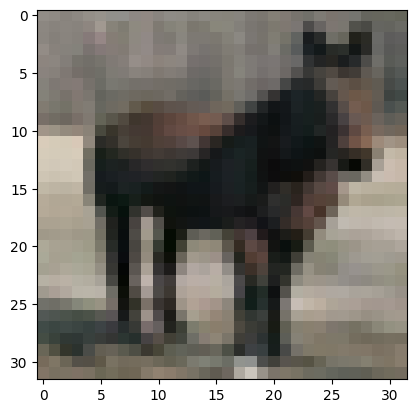

In [167]:
def sample_image():
    idx = np.random.randint(len(train_dataset))
    idxs.append(idx)
    return idx

# idx = sample_image()
idx = 39512
img, _ = train_dataset[idx]

# some janky code to unnormalize the image
mean, std = test_dataset.mean, test_dataset.std
img_show = img.cpu().detach().numpy().transpose(1, 2, 0) 
img_show = img_show*std + mean
img_show = np.clip(img_show, 0, 1)
plt.imshow(img_show)

In [140]:
idxs

[15430, 48600, 39512]

In [168]:
interact(visualize_feature_maps, model=fixed(model), img=fixed(img), layer=[1, 2, 4, 5, 6], device=fixed(device))

interactive(children=(Dropdown(description='layer', options=(1, 2, 4, 5, 6), value=1), Output()), _dom_classes…

<function __main__.visualize_feature_maps(model, img, layer, device)>

In [126]:
interact(visualize_model_weights, model=fixed(model), layer=[0, 4], channel=(0, 15, 1), mode=['individual', 'mean', 'color'])

interactive(children=(Dropdown(description='layer', options=(0, 4), value=0), IntSlider(value=0, description='…

<function __main__.visualize_model_weights(model, layer, channel=0, mode='individual')>

Observations: 
1. Channel 8 seems to be detecting horizontal edges very consistently. 
2. Channel 6, seems to be detecting the soil very well, on looking at the color map, It has high red and yellow components. So makes sense? Consistent in images: 15430, 48600, in image 39512, we find that it segments out the entire brown horse! It also weakly activates on the yellow soil, but is removed by relu later. Pretty interesting!

Can you find anything interesting?

I have attached some early vision stuff found in the first two layers found in an inceptionV1 net. These are powerful models and are trained on datasets like imagenet, and for a really long time! They also use large kernels so we can find more interesting things like clear gabor filters inside it. Later layers have things like triangle and curve detectors, which I haven't included here. You should read the [blog](https://distill.pub/2020/circuits/early-vision/) about it, it is really interesting.

<details>
<summary> layer 1 </summary>
<img src = "./resources/imgs/conv2d0.png" width=1200px>
</details>

<details>
<summary> layer 2 </summary>
<img src = "./resources/imgs/conv2d1.png" width=1200px>
</details>

#### Max activating neurons

### Vision Transformers

Let's get a basic overview of vision transformers. Then we'll see what can we interpret there!



Pros and cons of interpreting networks this way:

Pros-
1. We know exactly what is going on in a neural level, which is an extremely good thing for safety
2. Gives us a good idea of making better models. eg: Gabor CNNs

Cons-
1. Not reproducible to other networks.
2. Not tractable to fully reverse engineer large nets like this. There is a lot of work going on to automate this stuff, but still doesn't seem like a good idea to completely reverse engineer things. We might be able to test some hypothesis automatically though. 
3. Hypothesis is not easily verifiable and is limited to our own intelligence/capabilities. eg: superposition. Explaining a model might not even be human interpretable: if alphafold discovers a new way of protein folding, we might not even undertand it at first! (taken from somewhere in Colah's blog :p)


### Advances 

I will explain the things partially ordered wrt how many good explanations of these things are out there vs how important these are. 

#### Neural Rendering


<img src="./resources/imgs/nerfs.png" width=1200px>

#### Transfer Learning

`TODO`: 
1. basic freezing layers, catastrophic forgetting, etc. ref: https://www.analyticsvidhya.com/blog/2021/10/understanding-transfer-learning-for-deep-learning/
2. A breif overview of LORA, if not done before

#### pix to pix

Q. What do you think are some of the applications of this? Go back to the graph.

#### 1. FCNs
The main idea behind it is transpose convs. It allows you to 'increase' the resolution of the feature maps. Nowmally, you decrease it with strided convs. A very large padding doesn't really do anything meaningful. 

<img src = "./resources/imgs/transpose_conv.png" width=600px>

Let's take a case where you need to fully reconstruct the image. A U-Net(~2016) is (still) a very popular approach to this. It uses skip connections(something like residual layers to get back the information). Philosophically, you still want to compress the image to a tiny space. This is because 

1. you want to learn meaning dimensions/transform out of the random variable 
2. It can overfit to the identity function if not adding a bias like this!

<details>
<summary> U-Net architecture</summary>
<img src="./resources/imgs/unet.png" width = 1200px>
</details>

`TODO`: 
VAEs, GANs, stable diffusion (based on how much time needed and importance)


### Safety
Main tradeoff: How safe can models be without significantly harming it's performance? 

Not to be confused with a separate topic, alignment, which considers how will a broad AGI look like and can we prove that it won't be malicious? It deals specifically with x-risk/s-risk. Although some topics under here can directly contribute to the field... 
<!-- see [concrete problems](https://arxiv.org/pdf/1606.06565v1.pdf) for an in depth review -->

#### 1. Robustness
The idea is to strictly verify/claim that a model is robust to certain types of defects.

3 types:
1. Adverserial  
2. $L_\infty$ (strict verifiers found)/$L_p$(training methods with pac bounds found) norm based robustness
3. Realistic robustness

#### 2. Trojans
The adversary puts out certain trigger patterns in unsuspecting training data in the wild. The model trained on this data learns to detect this pattern and behaves maliciously whenever this pattern is observed. There is a [neurips competition](https://trojandetection.ai/) going on for this thing!

<img src="./resources/imgs/trojan.png">

#### 3. Black Swans

In a nutshell, Black Swan are random and unexpected phenomenon that carry a big or disproportional impact([link](https://jrodthoughts.medium.com/the-black-swan-problem-in-artificial-intelligence-part-i-74306aee0156)). So the problem statement is, how do we avoid high-impact outliers(heavy tailed risks)? This is probably more relevant for agents/broad agis, but you can see its significance in high reliability CV systems(like autonomous driving, etc).

#### 4. Privacy
Types of violition:

1. Model stealing
    - by using proxy models/data/data generators
    - by exploiting stability
2. Your data is known to anyone who sees the server. Possible solutions: Palier Homography
3. Model learning user data. Can you unlearn it?

#### 5. Interpretability and Explainability 
We saw this before!

`Thank you!`

        -Rohan, 
        [my github username]@gmail.com